In [547]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

from prophet import Prophet


Calculating MAPE given y_true and y_pred


In [548]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true,y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true)) * 100
   

In [549]:
mock_kaggie= pd.read_csv("C:/Users/kelfin.njagi/Documents/ML_Projects/Sales_Forecasting/Data/mock_kaggle.csv",
                  index_col=[0],
                  parse_dates=[0])


In [550]:
mock_kaggie = mock_kaggie.rename(
    columns={
        'data': 'date',
        'venda': 'sales',
        'estoque': 'stock',
        'preco': 'price'
    }
)
mock_kaggie = mock_kaggie.rename_axis("date") #Renaming the date, since its in the index position and not column position

#mock_kaggie.head()
print(mock_kaggie.columns)
print(mock_kaggie.head())

Index(['sales', 'stock', 'price'], dtype='object')
            sales  stock  price
date                           
2014-01-01      0   4972   1.29
2014-01-02     70   4902   1.29
2014-01-03     59   4843   1.29
2014-01-04     93   4750   1.29
2014-01-05     96   4654   1.29


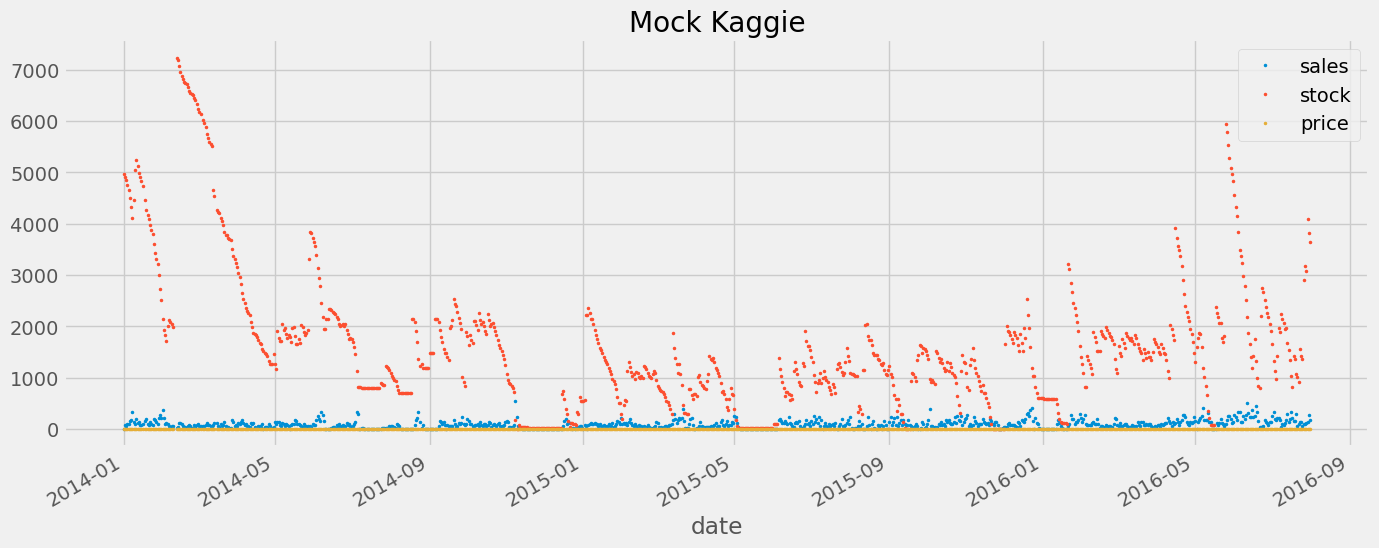

In [551]:
color_pal = sns.color_palette()
mock_kaggie.plot(style='.',
           figsize=(15,6),
           ms=3,
           #color=color_pal[0],
           title='Mock Kaggie')
plt.show()
           

In [552]:
# Finding the total length of the data
n = len(mock_kaggie)

# 70% split point (rounded down)
split_point = int(n * 0.7)

# Getting the index at that split
split_date = mock_kaggie.index[split_point]

# Now splitting using that date
mock_kaggie_train = mock_kaggie.loc[mock_kaggie.index <= split_date].copy()
mock_kaggie_test  = mock_kaggie.loc[mock_kaggie.index > split_date].copy()

print("Total samples:", n)
print("Train samples:", len(mock_kaggie_train))
print("Test samples:", len(mock_kaggie_test))
print("Split date:", split_date)

Total samples: 937
Train samples: 656
Test samples: 281
Split date: 2015-10-24 00:00:00


In [553]:
# Train / Test Split
split_date = '24-oct-2015'
mock_kaggie_train = mock_kaggie.loc[mock_kaggie.index<= split_date].copy()
mock_kaggie_test = mock_kaggie.loc[mock_kaggie.index> split_date].copy()



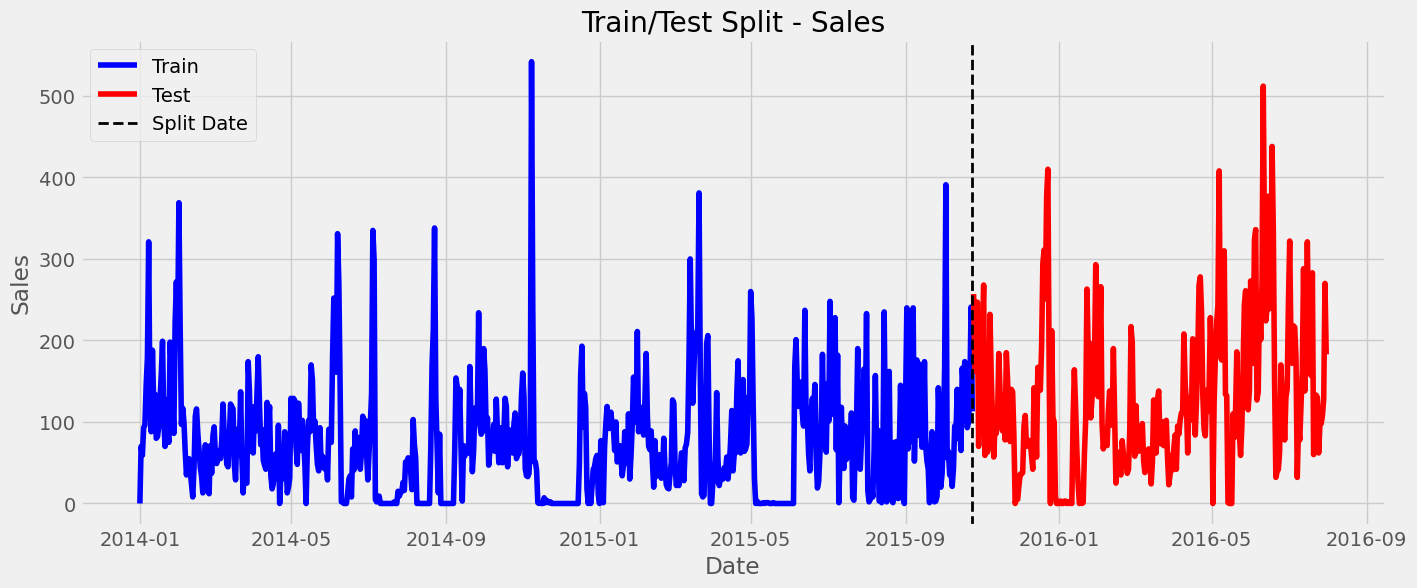

In [554]:
plt.figure(figsize=(15,6))

# Plot train in blue
plt.plot(mock_kaggie_train.index, mock_kaggie_train['sales'], color='blue', label='Train')

# Plot test in red
plt.plot(mock_kaggie_test.index, mock_kaggie_test['sales'], color='red', label='Test')

# Add vertical line for split
plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', lw=2, label='Split Date')

plt.title("Train/Test Split - Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


Renaming the column and the date for us to use prophet

In [555]:
mock_kaggie_train_Prophet = mock_kaggie_train.reset_index() \
    .rename(columns={'date':'ds',
                     'sales': 'y'})
mock_kaggie_train_Prophet.head()

,ds,y,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [556]:
%%time
model= Prophet()
model.fit(mock_kaggie_train_Prophet)

15:47:47 - cmdstanpy - INFO - Chain [1] start processing
15:47:47 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 31.2 ms
Wall time: 282 ms


Predict on test set with model


In [557]:
mock_kaggie_test_Prophet = mock_kaggie_test.reset_index() \
    .rename(columns={'date':'ds',
                    'sales':'y'})
mock_kaggie_test_forecast= model.predict(mock_kaggie_test_Prophet)

In [558]:
mock_kaggie_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-25,90.255691,5.628413,175.030814,90.255691,90.255691,3.974584,3.974584,3.974584,3.974584,3.974584,3.974584,0.0,0.0,0.0,94.230275
1,2015-10-26,90.344861,-18.019563,156.186566,90.344861,90.344861,-17.990277,-17.990277,-17.990277,-17.990277,-17.990277,-17.990277,0.0,0.0,0.0,72.354585
2,2015-10-27,90.434031,-12.396376,156.275188,90.434031,90.434031,-21.535928,-21.535928,-21.535928,-21.535928,-21.535928,-21.535928,0.0,0.0,0.0,68.898103
3,2015-10-28,90.523202,3.043964,169.001514,90.523202,90.523202,-5.570715,-5.570715,-5.570715,-5.570715,-5.570715,-5.570715,0.0,0.0,0.0,84.952486
4,2015-10-29,90.612372,2.129811,161.246300,90.612372,90.612372,-10.050815,-10.050815,-10.050815,-10.050815,-10.050815,-10.050815,0.0,0.0,0.0,80.561556


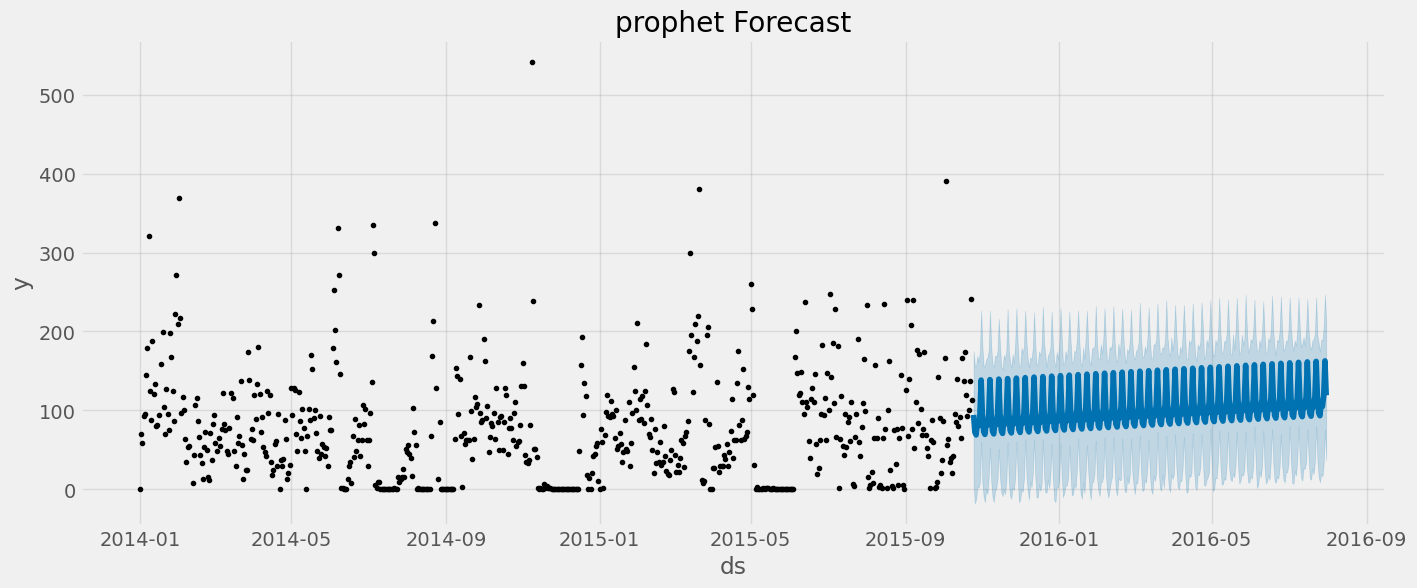

In [559]:
fig, ax = plt.subplots(figsize=(15,6))
fig= model.plot(mock_kaggie_test_forecast, ax=ax)
ax.set_title('prophet Forecast')
plt.show()

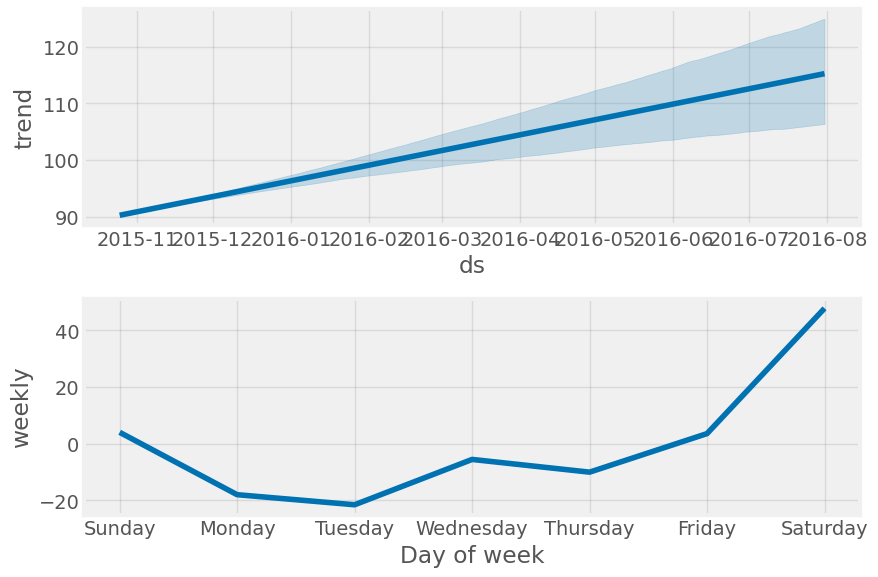

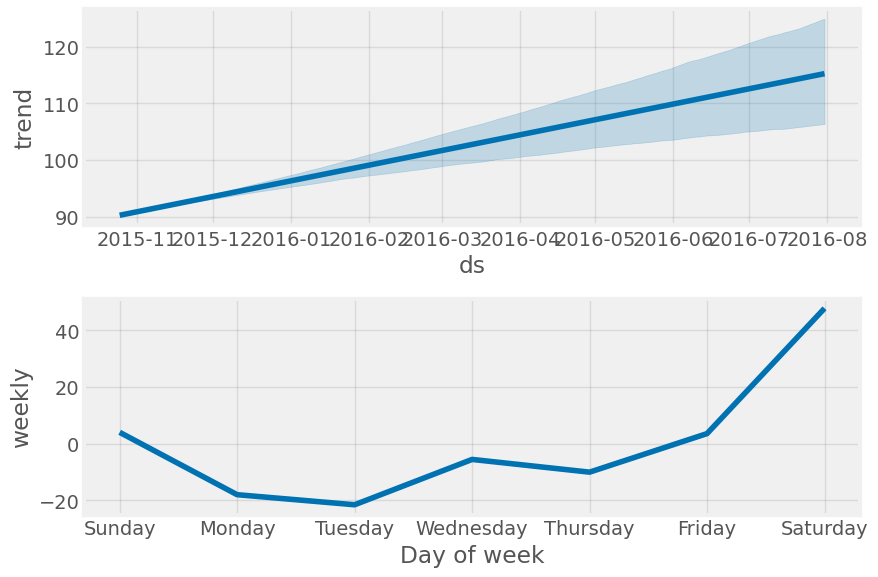

In [560]:
model.plot_components(mock_kaggie_test_forecast)

Text(0.5, 1.0, 'Prophet Forecast vs Actual Sales')

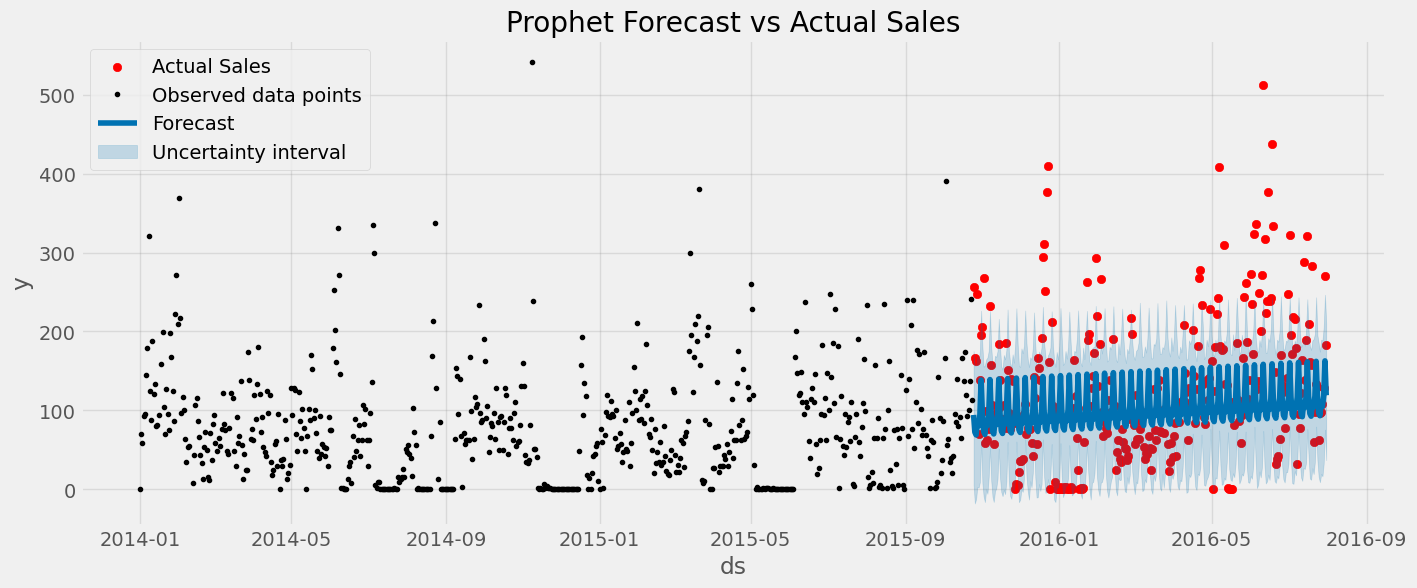

In [561]:
f, ax = plt.subplots(figsize=(15,6))

# Plot actual sales (red dots)
ax.scatter(mock_kaggie_test.index,
           mock_kaggie_test['sales'],
           color='r',
           label='Actual Sales')

# Plot Prophet forecast
fig = model.plot(mock_kaggie_test_forecast, ax=ax)

# Add legend (key)
ax.legend()

# Title
ax.set_title("Prophet Forecast vs Actual Sales")


In [562]:
#print(mock_kaggie_test['sales']['2015-12'].head())
#print(mock_kaggie_test['sales']['2015-12'].max())


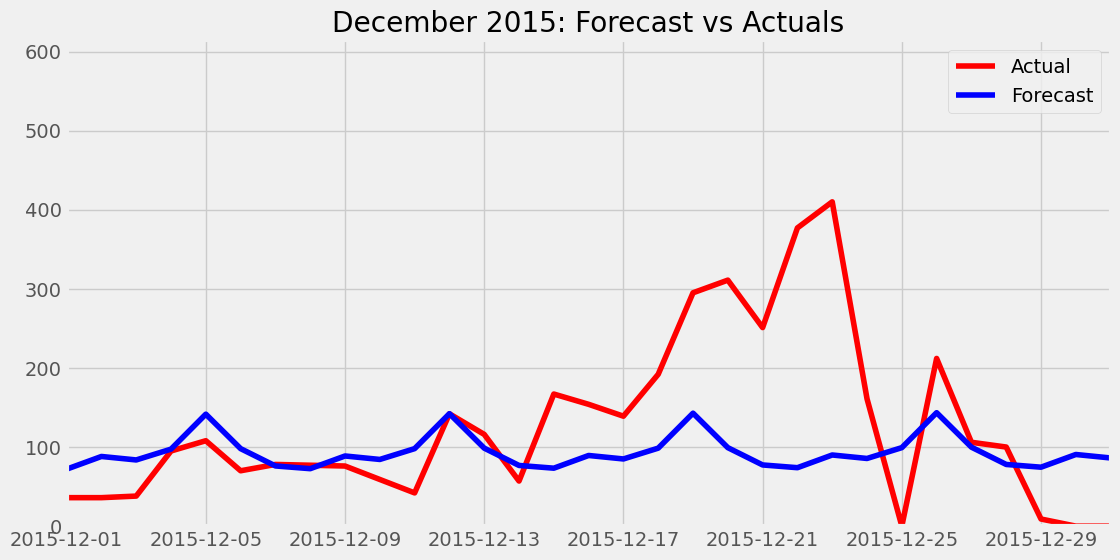

In [563]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot actual sales in red
ax.plot(mock_kaggie_test.index, mock_kaggie_test['sales'], color='red', label='Actual')

# Plot Prophet forecast in blue
ax.plot(mock_kaggie_test_forecast['ds'], mock_kaggie_test_forecast['yhat'], color='blue', label='Forecast')

# Limit x-axis to Dec 2015
ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2015-12-31'))

# Scale y-axis automatically based on actual & forecast
ax.set_ylim(0, max(mock_kaggie_test['sales'].max(), mock_kaggie_test_forecast['yhat'].max()) * 1.2)

ax.set_title('December 2015: Forecast vs Actuals')
ax.legend()
plt.show()



Evaluate the model with error Metrics

In [564]:
np.sqrt(mean_squared_error(y_true=mock_kaggie_test['sales'],
                          y_pred=mock_kaggie_test_forecast['yhat']))

89.15083609330898

In [565]:
mean_absolute_error(y_true=mock_kaggie_test['sales'],
                   y_pred=mock_kaggie_test_forecast['yhat'])

65.85418264733605

In [566]:

mae = mean_absolute_error(mock_kaggie_test['sales'], mock_kaggie_test_forecast['yhat'])
mean_sales = mock_kaggie_test['sales'].mean()
mae_percent = (mae / mean_sales) * 100
print("MAE as % of average sales:", mae_percent)


MAE as % of average sales: 51.83044932891194


In [567]:
#print(mock_kaggie.index)


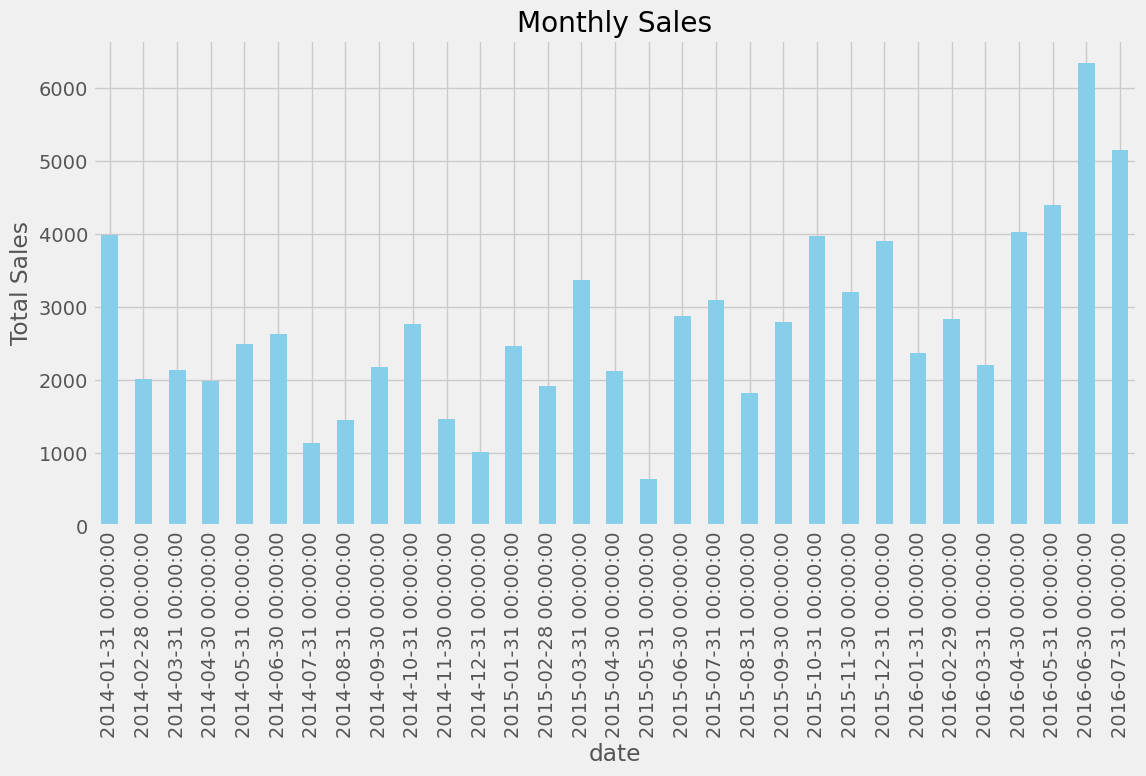

Low season months:
 date
2014-02-28    2018
2014-03-31    2137
2014-04-30    1990
2014-05-31    2493
2014-06-30    2629
2014-07-31    1131
2014-08-31    1452
2014-09-30    2185
2014-11-30    1462
2014-12-31    1010
2015-01-31    2465
2015-02-28    1918
2015-04-30    2123
2015-05-31     647
2015-08-31    1826
2016-01-31    2365
2016-03-31    2206
Name: sales, dtype: int64


In [568]:
monthly_sales = mock_kaggie['sales'].resample('M').sum()

# Plot monthly sales
monthly_sales.plot(kind='bar', figsize=(12,6), color='skyblue', title='Monthly Sales')
plt.ylabel('Total Sales')
plt.show()

# Identify low season months
low_season = monthly_sales[monthly_sales < monthly_sales.mean()]
print("Low season months:\n", low_season)


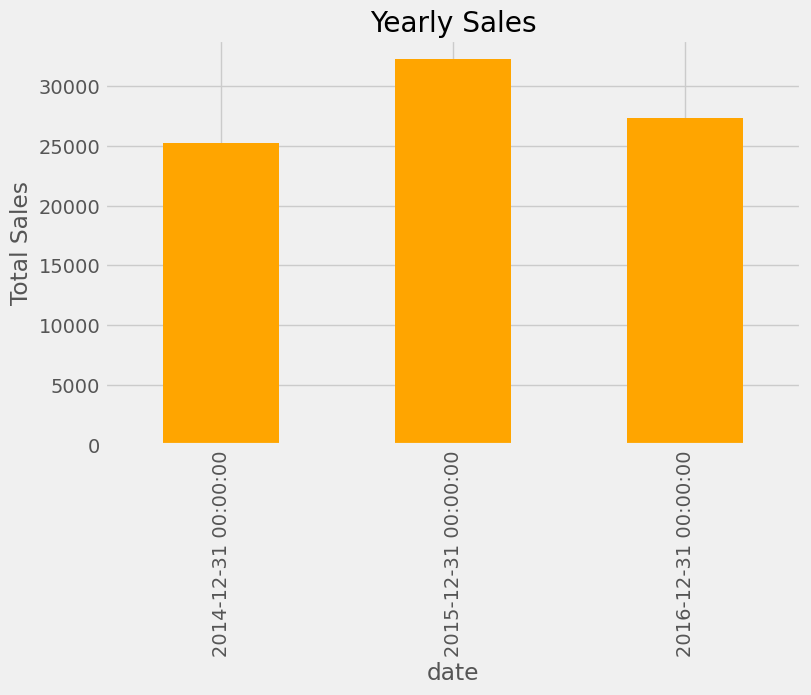

In [569]:
# Ensure index is datetime
mock_kaggie.index = pd.to_datetime(mock_kaggie.index)

# Resample yearly
yearly_sales = mock_kaggie['sales'].resample('Y').sum()

# Plot yearly sales
yearly_sales.plot(kind='bar', figsize=(8,5), color='orange', title="Yearly Sales")
plt.ylabel("Total Sales")
plt.show()


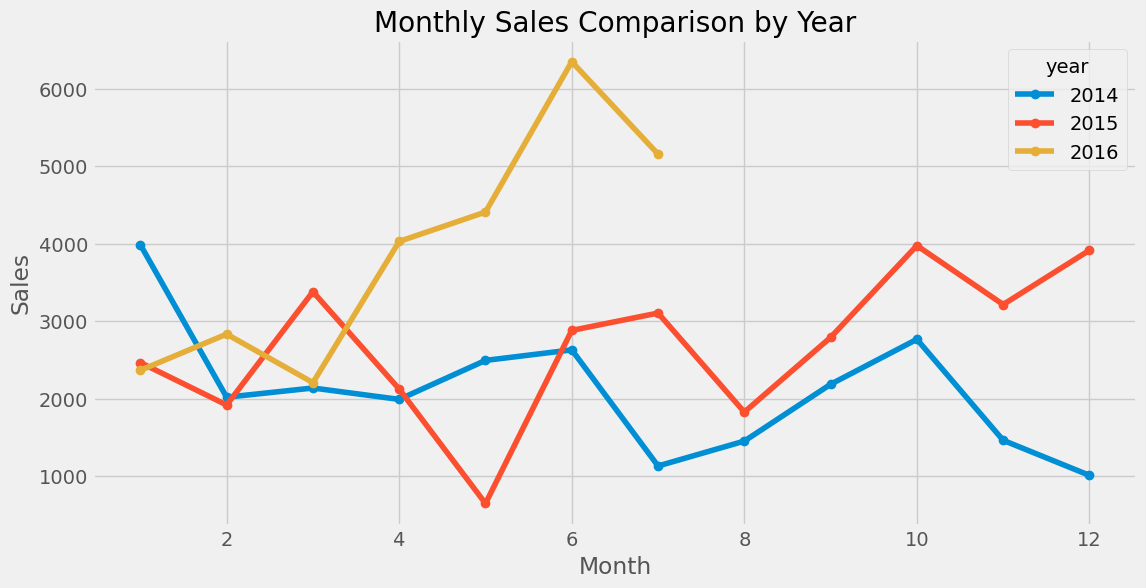

In [570]:
# Ensure index is datetime
mock_kaggie.index = pd.to_datetime(mock_kaggie.index)

# Extract year and month from index
mock_kaggie['year'] = mock_kaggie.index.year
mock_kaggie['month'] = mock_kaggie.index.month

# Pivot table: months as rows, years as columns
monthly_by_year = mock_kaggie.pivot_table(
    values='sales',
    index='month',
    columns='year',
    aggfunc='sum'
)

# Plot
monthly_by_year.plot(figsize=(12,6), marker='o')
plt.title("Monthly Sales Comparison by Year")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.show()



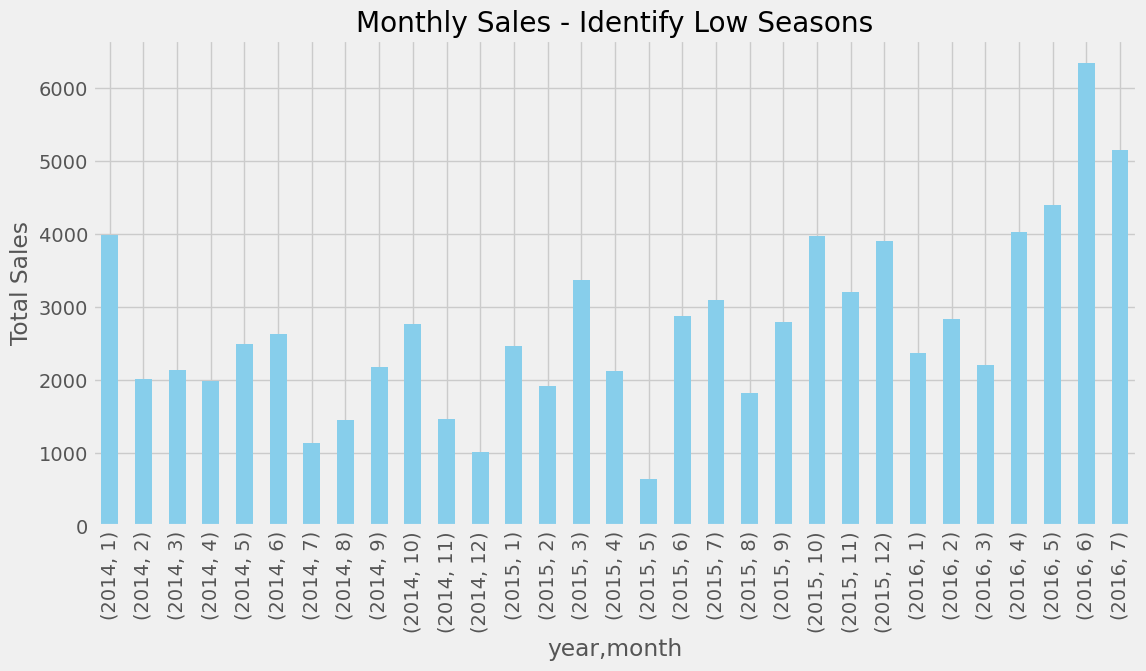

Low season months:
 year  month
2014  2        2018
      3        2137
      4        1990
      5        2493
      6        2629
      7        1131
      8        1452
      9        2185
      11       1462
      12       1010
2015  1        2465
      2        1918
      4        2123
      5         647
      8        1826
2016  1        2365
      3        2206
Name: sales, dtype: int64


In [571]:
# Monthly sales (all categories combined)
monthly_sales = mock_kaggie.groupby(['year','month'])['sales'].sum()

# Plot
monthly_sales.plot(kind='bar', figsize=(12,6), color='skyblue', title='Monthly Sales - Identify Low Seasons')
plt.ylabel('Total Sales')
plt.show()

# Low season months (below average sales)
low_season = monthly_sales[monthly_sales < monthly_sales.mean()]
print("Low season months:\n", low_season)


In [572]:
mock_kaggie['price'] = pd.to_numeric(mock_kaggie['price'], errors='coerce')


In [573]:
mock_kaggie['price_range'] = pd.cut(
    mock_kaggie['price'],
    bins=[0, 1.3, 1.5, mock_kaggie['price'].max()],
    labels=['Low', 'Medium', 'High']
)


In [574]:
# Ensure index is datetime
mock_kaggie.index = pd.to_datetime(mock_kaggie.index)

# Extract year and month from index
mock_kaggie['year'] = mock_kaggie.index.year
mock_kaggie['month'] = mock_kaggie.index.month

# Quick check - first 500 rows
print(mock_kaggie.head(500))


            sales  stock  price  year  month price_range
date                                                    
2014-01-01      0   4972   1.29  2014      1         Low
2014-01-02     70   4902   1.29  2014      1         Low
2014-01-03     59   4843   1.29  2014      1         Low
2014-01-04     93   4750   1.29  2014      1         Low
2014-01-05     96   4654   1.29  2014      1         Low
...           ...    ...    ...   ...    ...         ...
2015-05-17      0     10   1.49  2015      5      Medium
2015-05-18      0     10   1.49  2015      5      Medium
2015-05-19      1      9   1.49  2015      5      Medium
2015-05-20      0      9   1.49  2015      5      Medium
2015-05-21      0      9   1.49  2015      5      Medium

[500 rows x 6 columns]


In [575]:
# Total Sales
total_sales = mock_kaggie['sales'].sum()

# Average Daily Sales
avg_daily_sales = mock_kaggie['sales'].mean()

# Monthly Sales for Peak/Low Season
monthly_sales = mock_kaggie.groupby([mock_kaggie.index.year, mock_kaggie.index.month])['sales'].sum()

# Low and peak season
low_season_month = monthly_sales.idxmin()
low_season_sales = monthly_sales.min()

peak_month = monthly_sales.idxmax()
peak_sales = monthly_sales.max()

# Print insight cards
print(" Insight Cards for Decision-Making\n")
print(f"1️. Total Sales: {total_sales}")
print(f"2️. Average Daily Sales: {avg_daily_sales:.2f}")
print(f"3️. Peak Sales Month: {peak_month} ({peak_sales} sales)")
print(f"4️. Low Season Month: {low_season_month} ({low_season_sales} sales)")


 Insight Cards for Decision-Making

1️. Total Sales: 84830
2️. Average Daily Sales: 90.53
3️. Peak Sales Month: (2016, 6) (6347 sales)
4️. Low Season Month: (2015, 5) (647 sales)
